In [15]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [16]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import rand
pd.options.display.max_colwidth = 600
import h5py
# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# Matplot Imports
import matplotlib.pyplot as plt

In [17]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [18]:
BATCH_SIZE = 32
epoch = 5
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [19]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [20]:
mean = np.mean(X_train,axis=(0,1,2,3))
std = np.std(X_train,axis=(0,1,2,3))
X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [22]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [23]:
X_train.shape

(42500, 32, 32, 3)

In [24]:
import cv2
X_train = np.array([cv2.resize(x,(48,48)) for x in X_train])
X_val = np.array([cv2.resize(x,(48,48)) for x in X_val])
X_test = np.array([cv2.resize(x,(48,48)) for x in X_test])

In [25]:
X_train.shape

(42500, 48, 48, 3)

In [26]:
# X_train = tf.keras.applications.vgg16.preprocess_input(X_train)
# X_val = tf.keras.applications.vgg16.preprocess_input(X_val)
# X_test = tf.keras.applications.vgg16.preprocess_input(X_test)

In [27]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [28]:
last = base_model.get_layer('block3_pool').output
avg = tf.keras.layers.GlobalAveragePooling2D()(last)
cust_cnn = BatchNormalization()(avg)
cust_cnn = Dense(256, activation='relu')(cust_cnn)
cust_cnn = Dense(256, activation='relu')(cust_cnn)
cust_cnn = Dropout(0.5)(cust_cnn)
pred = Dense(10, activation='softmax')(cust_cnn)
model = Model(base_model.input, pred)

In [29]:
for layer in base_model.layers:
     layer.trainable = True

In [30]:
# def lr_schedule(epoch):
#     lrate = 0.001
#     if epoch > 50:
#         lrate = 0.0005
#     if epoch > 80:
#         lrate = 0.0001
#     if epoch > 100:
#         lrate = 0.00005
#     if epoch > 120:
#         lrate = 0.00001
#     return lrate

In [31]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)      

In [33]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

In [34]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy',baseline='0.9')

In [37]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),\
                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,epochs=45,\
                    verbose=1,validation_data=(X_val,Y_val))

Epoch 1/45
1328/1328 [==============================] - 44s 33ms/step - loss: 0.8480 - accuracy: 0.7140 - val_loss: 0.7845 - val_accuracy: 0.7315
Epoch 2/45
1328/1328 [==============================] - 43s 32ms/step - loss: 0.7538 - accuracy: 0.7465 - val_loss: 0.6946 - val_accuracy: 0.7631
Epoch 3/45
1328/1328 [==============================] - 43s 32ms/step - loss: 0.6775 - accuracy: 0.7725 - val_loss: 0.9040 - val_accuracy: 0.7208
Epoch 4/45
1328/1328 [==============================] - 43s 32ms/step - loss: 0.6181 - accuracy: 0.7942 - val_loss: 0.6579 - val_accuracy: 0.7873
Epoch 5/45
1328/1328 [==============================] - 43s 32ms/step - loss: 0.5749 - accuracy: 0.8075 - val_loss: 0.5635 - val_accuracy: 0.8153
Epoch 6/45
1328/1328 [==============================] - 43s 32ms/step - loss: 0.5409 - accuracy: 0.8193 - val_loss: 0.5194 - val_accuracy: 0.8233
Epoch 7/45
1328/1328 [==============================] - 42s 32ms/step - loss: 0.5105 - accuracy: 0.8310 - val_loss: 0.5154 -

In [59]:
# model.save('CIFAR_TF_ver_2.h5') 
# model.history.history

In [55]:
from keras.models import load_model 
import numpy as np
# model = load_model('CIFAR_TF_ver_2.h5')
np.save('model_history.npy',model.history.history) # Saving Model history to plot accuracy plots later

In [67]:
history_of_model=np.load('model_history.npy',allow_pickle='TRUE').item()
print(history_of_model)

{'loss': [0.8480274677276611, 0.7538004517555237, 0.6774652004241943, 0.6180837750434875, 0.5749370455741882, 0.5409276485443115, 0.5104835629463196, 0.477076917886734, 0.455490380525589, 0.42548853158950806, 0.4134719669818878, 0.3838558495044708, 0.3779584765434265, 0.35502007603645325, 0.34563204646110535, 0.33379000425338745, 0.32458558678627014, 0.3045596778392792, 0.3000198304653168, 0.2837684750556946, 0.2807844281196594, 0.2669062614440918, 0.26408764719963074, 0.25716885924339294, 0.2459755539894104, 0.24024368822574615, 0.2342108190059662, 0.23055553436279297, 0.22074007987976074, 0.2140309363603592, 0.20661363005638123, 0.21145229041576385, 0.20287230610847473, 0.19519805908203125, 0.1961095780134201, 0.1806674301624298, 0.18579323589801788, 0.19146935641765594, 0.17613117396831512, 0.1800934076309204, 0.1690928339958191, 0.16372893750667572, 0.16144803166389465, 0.16491864621639252, 0.16184371709823608], 'accuracy': [0.7140199542045593, 0.7464679479598999, 0.772487521171569

In [81]:
# plotting helper function
def plothist(hist):
    plt.figure(figsize=(12,5))
    plt.plot(hist['accuracy'])
    plt.plot(hist['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

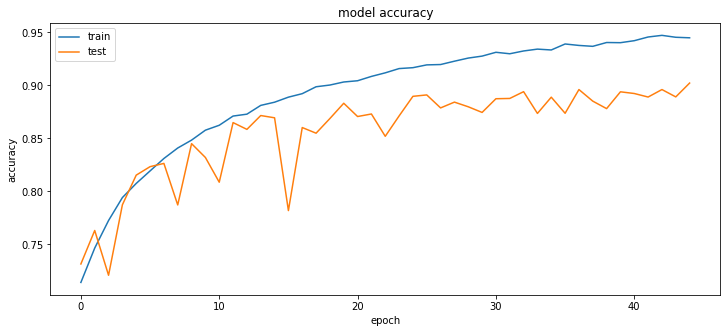

In [82]:
plothist(history_of_model)

In [60]:
print('Testing Accuracy : ')
model.evaluate(X_test, Y_test)

Testing Accuracy : 
313/313 [==============================] - 2s 7ms/step - loss: 0.3935 - accuracy: 0.9025


[0.39351126551628113, 0.9024999737739563]

In [61]:
print('Training Accuracy : ')
model.evaluate(X_train, Y_train)

Training Accuracy : 
1329/1329 [==============================] - 9s 7ms/step - loss: 0.0831 - accuracy: 0.9765


[0.08305804431438446, 0.9764705896377563]

In [62]:
print('Validation Accuracy : ')
model.evaluate(X_val, Y_val)

Validation Accuracy : 
235/235 [==============================] - 2s 7ms/step - loss: 0.3755 - accuracy: 0.9023


[0.37548571825027466, 0.9022666811943054]